# 2-D Path Planning using splines and SVGD Kernels

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sigkernel
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

from stein_mpc.inference import SVGD
from stein_mpc.kernels import GaussianKernel, PathSigKernel

In [2]:
def create_spline_trajectory(knots, timesteps=100):
    t = torch.linspace(0, 1, timesteps)
    t_knots = torch.linspace(0, 1, knots.shape[-2])
    coeffs = natural_cubic_spline_coeffs(t_knots, knots)
    spline = NaturalCubicSpline(coeffs)
    return spline.evaluate(t)

def plot_2d_dist(log_p, x_lim=(0.0, 3.5), y_lim=(-2.0, 2.5), grid_size=100):
    x = torch.linspace(*x_lim, grid_size)
    y = torch.linspace(*y_lim, grid_size)
    X, Y = torch.meshgrid(x,y)
    Z = torch.exp(log_p(torch.stack((X.flatten(), Y.flatten()), dim=0).T)).reshape(grid_size, grid_size)

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.contourf(X, Y, Z.data.numpy(), 30)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim) 
    return fig, ax

def create_2d_movie(data, log_p, x_lim=(0.0, 3.5), y_lim=(-2.0, 2.5), grid_size=100, n_iter=100, save_path="movie.mp4"):
    fig, ax = plot_2d_dist(log_p, x_lim, y_lim, grid_size)
    container = []
    for i in range(n_iter):
        im = []
        # list of [batch] lines
        im.extend(ax.plot(data["traj"][i, ..., 0].T, data["traj"][i, ..., 1].T, color='orange', animated=True))
        # list of [batch] knots
        im.extend(ax.plot(data["knots"][i, ..., 0], data["knots"][i, ..., 1], 'ob', animated=True))
        title = ax.text(0.5, 0.1, "Current iteration: {}".format(i), bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
        im.extend([title])
        container.append(im)

    ani = animation.ArtistAnimation(fig, container, interval=50, blit=True)
    ani.save(filename=save_path)

## Problem setup

In [3]:
# Two gaussian obstacles
w = torch.tensor([0.5, 0.5])
mean = torch.tensor([[1., 1.], [2, 1.25]])
var  = torch.tensor([[.25, .25], [.25, .25]])
mix = dist.Categorical(w)
comp = dist.Independent(dist.Normal(mean, var), 1)
log_p = dist.MixtureSameFamily(mix, comp).log_prob

# Defines the cost function as a function of x which is a 3 x 2 differentiable vector 
# defining the intermediate knots of the spline
def cost_function(log_p, x, start_pose, target_pose, timesteps=100, w=5.0):
    knots  = torch.cat((start_pose.unsqueeze(0), x, target_pose.unsqueeze(0)), 0)
    out = create_spline_trajectory(knots, timesteps)
    return (log_p(out).exp()).sum() + (w * torch.norm(out[1:, :] - out[:-1, :])).exp()

def batch_cost_function(log_p, x, start_pose, target_pose, timesteps=100, w=1.0):
    batch = x.shape[0]
    knots = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
    traj = create_spline_trajectory(knots, timesteps)
    cost = log_p(traj).exp().sum(-1) + w * (traj[:, 1:] - traj[:, :-1]).norm(dim=[-2, -1])
    return cost, traj

## Single Trajectory Case

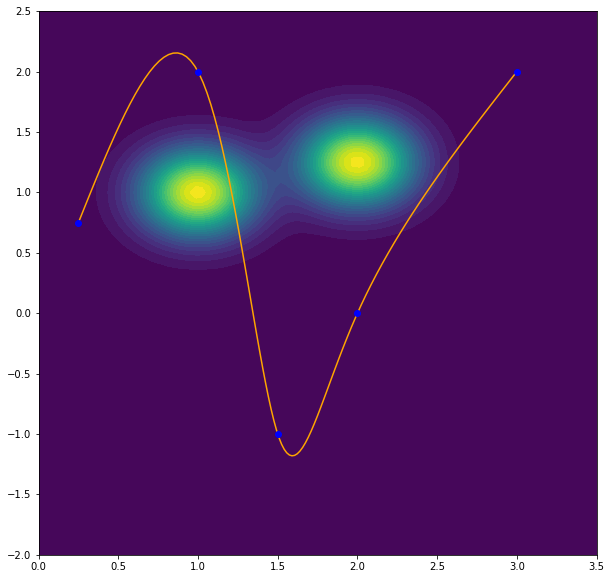

In [5]:
length, channels = 5, 2
start_pose = torch.tensor([0.25, 0.75])
target_pose = torch.tensor([3.0, 2.0])
sample_knots = torch.tensor([[1., 2.0], [1.5, -1.0], [2.0, 0.0]])
knots  = torch.cat((start_pose.unsqueeze(0), sample_knots, target_pose.unsqueeze(0)), 0)


# Plot an initial spline
traj = create_spline_trajectory(knots)

plot_2d_dist(log_p)
plt.plot(traj[:, 0], traj[:, 1], color='orange')
plt.plot(knots[:, 0], knots[:, 1], 'ob')
plt.show()

In [5]:
# Sets up the optimization problem
x = torch.tensor([[1., 2.0], [1.5, -1.0], [2.0, 0.0]]).requires_grad_(True)

optimizer = torch.optim.Adam(params=[x], lr=.1)
n_iter = 500

def step(x):
    optimizer.zero_grad()
    cost = cost_function(log_p, x, start_pose, target_pose)
    d_cost = -torch.autograd.grad(cost, x, create_graph=True)[0]
    x.grad = -d_cost
    optimizer.step()
    
for i in range(n_iter):
    step(x)
    
x = x.detach()

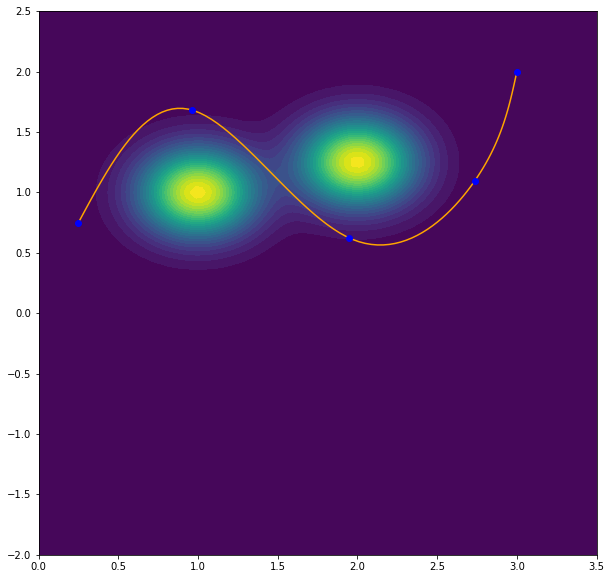

In [6]:
# Plots the solution
knots = torch.cat((start_pose.unsqueeze(0), x, target_pose.unsqueeze(0)), 0)
traj = create_spline_trajectory(knots)

plot_2d_dist(log_p)
plt.plot(traj[:, 0], traj[:, 1], color='orange')
plt.plot(knots[:, 0], knots[:, 1], 'ob')
plt.show()

## Batch Spline Optimisation

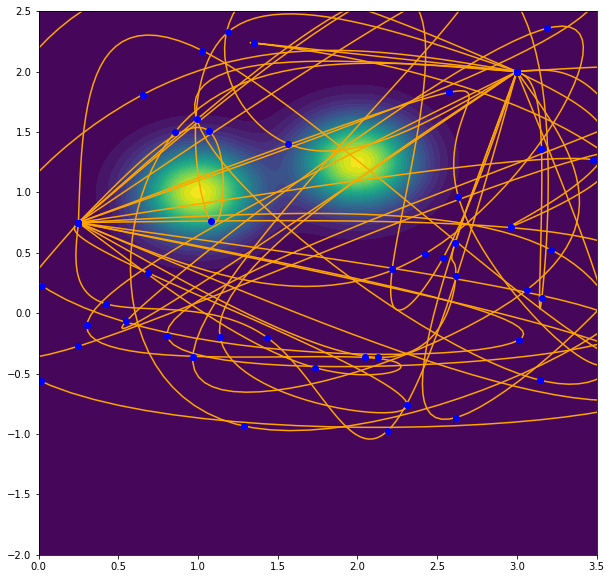

In [4]:
# This example illustrates batch splines optimisation given a cost function
torch.manual_seed(42)

# Samples points for multiple splines with the same start and target positions
batch, length, channels = 20, 5, 2
start_pose = torch.tensor([0.25, 0.75])
target_pose = torch.tensor([3.0, 2.0])
offset = torch.tensor([0., -1.])
x = 4 * torch.rand(batch, length - 2, channels) + offset 

initial_knots = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)

# Creates the splines
initial_traj = create_spline_trajectory(initial_knots)

# Plots the splines
plot_2d_dist(log_p)
plt.plot(initial_traj[..., 0].T, initial_traj[..., 1].T, color='orange')
plt.plot(initial_knots[..., 0], initial_knots[..., 1], 'ob')
plt.show()

#### Batch optimization using Gradient Descent

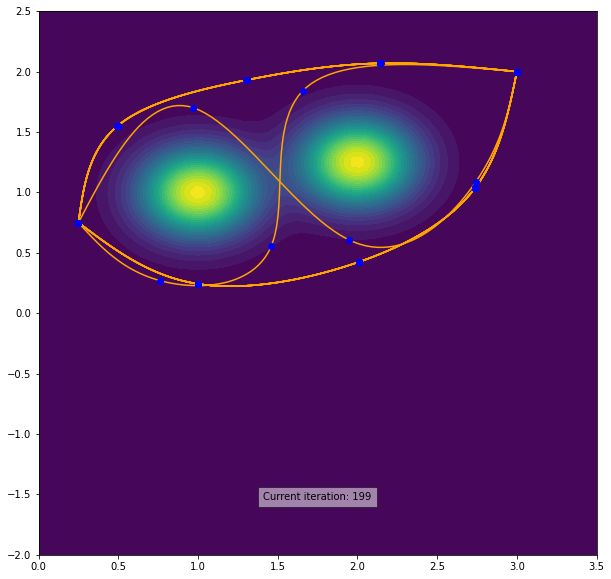

In [7]:
x = initial_knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 200
kernel = GaussianKernel()
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.05)

# need score estimator to include trajectory length regularization cost
def sgd_score_estimator(x):
    cost, _ = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0]
    k_xx = torch.eye(batch)
    grad_k = torch.zeros_like(grad_log_p)
    score_dict = {"k_xx": k_xx, "grad_k": grad_k}
    return grad_log_p, score_dict  
                    
data_dict, _ = stein_sampler.optimize(x, sgd_score_estimator, n_steps=n_iter)
x = x.detach()

# Plots the optimized splines
knots = torch.cat((start_pose.repeat(n_iter + 1, batch, 1, 1), data_dict["trace"], target_pose.repeat(n_iter + 1, batch, 1, 1)), dim=-2)
traj = create_spline_trajectory(knots)

create_2d_movie({"traj": traj, "knots": knots}, log_p, n_iter=n_iter, save_path="tests/sgd.mp4")

#### Batch optimization using SVGD

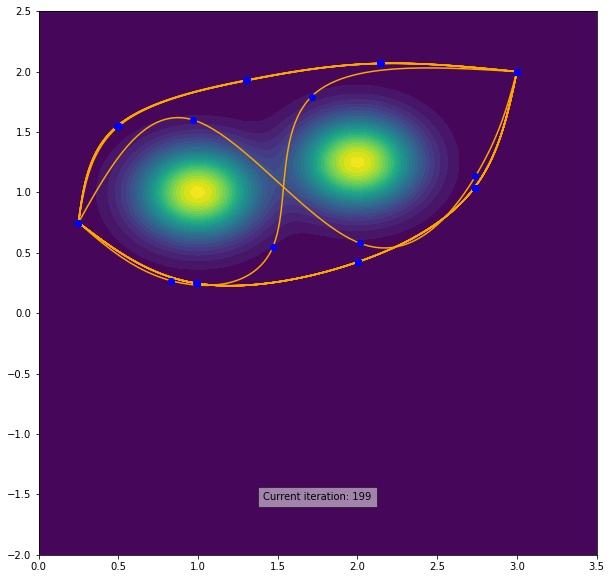

In [8]:
x = initial_knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 200
kernel = GaussianKernel()
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.05)

# need score estimator to include trajectory length regularization cost
def score_estimator(x):
    cost, _ = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0]
    score_dict = {}
    return grad_log_p, score_dict  
                    
data_dict, _ = stein_sampler.optimize(x, score_estimator, n_steps=n_iter)
x = x.detach()

# Plots the optimized splines
knots = torch.cat((start_pose.repeat(n_iter + 1, batch, 1, 1), data_dict["trace"], target_pose.repeat(n_iter + 1, batch, 1, 1)), dim=-2)
traj = create_spline_trajectory(knots)

create_2d_movie({"traj": traj, "knots": knots}, log_p, n_iter=n_iter, save_path="tests/svgd.mp4")

#### Batch optimization using Path Signature Kernel

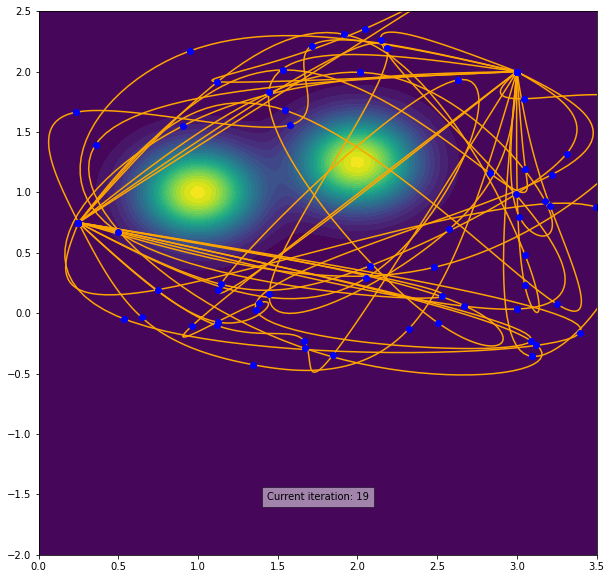

In [5]:
x = initial_knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 20
static_kernel = sigkernel.RBFKernel(sigma=0.5)
dyadic_order = 2
kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.05)

# need score estimator to include trajectory length regularization cost
def score_estimator(x):
    cost, traj = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0].flatten(1)
    k_xx = kernel.compute_Gram(traj.double(), traj.double())
    k_xx = k_xx.float()
    grad_k = torch.autograd.grad(k_xx.sum(), x)[0]
    score_dict = {"k_xx": k_xx.detach(), "grad_k": grad_k.detach()}
    return grad_log_p, score_dict  
                    
data_dict, _ = stein_sampler.optimize(x, score_estimator, n_steps=n_iter)
x = x.detach()
    
# Plots the optimized splines
knots = torch.cat((start_pose.repeat(n_iter + 1, batch, 1, 1), data_dict["trace"], target_pose.repeat(n_iter + 1, batch, 1, 1)), dim=-2)
traj = create_spline_trajectory(knots)

create_2d_movie({"traj": traj, "knots": knots}, log_p, n_iter=n_iter, save_path="tests/pathsig.mp4")

#### Batch optimization using a mix of SGD and Path Signature kernel

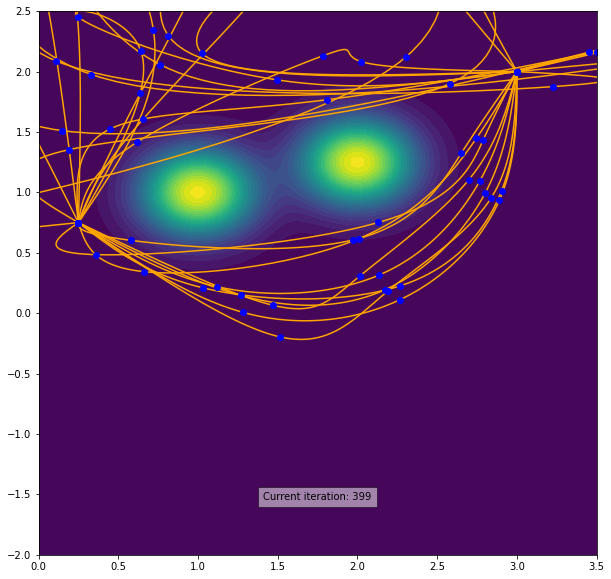

In [10]:
x = initial_knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 400
kernel = PathSigKernel(kernel_type="gaussian")
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.05)

# need score estimator to include trajectory length regularization cost
def sgd_score_estimator(x):
    cost, _ = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0]
    k_xx = torch.eye(batch)
    grad_k = torch.zeros_like(grad_log_p)
    score_dict = {"k_xx": k_xx, "grad_k": grad_k}
    return grad_log_p, score_dict  

def score_estimator(x):
    cost, traj = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0]
    k_xx, grad_k = kernel(traj, traj, x, depth=5)
    score_dict = {"k_xx": k_xx, "grad_k": grad_k}
    return grad_log_p, score_dict  
                    
data_dict_1, _ = stein_sampler.optimize(x, sgd_score_estimator, n_steps=n_iter//2)
data_dict_2, _ = stein_sampler.optimize(x, score_estimator, n_steps=(n_iter - n_iter//2))
trace = torch.cat([data_dict_1["trace"][:-1], data_dict_2["trace"]], dim=0)
x = x.detach()
    
# Plots the optimized splines
knots = torch.cat((start_pose.repeat(n_iter + 1, batch, 1, 1), trace, target_pose.repeat(n_iter + 1, batch, 1, 1)), dim=-2)
traj = create_spline_trajectory(knots)

create_2d_movie({"traj": traj, "knots": knots}, log_p, n_iter=n_iter, save_path="../tests/sgd_pathsig.mp4")